# Import

https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


# PD Setting


In [4]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#显示宽度
pd.set_option('display.width', 2000)

pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

In [5]:
MISSING_COLS =[]
DROP_COLS =[]
CAT_COLS =[]
NUM_COLS =[]
RATIO = 0

# Load Data

In [6]:
#load data
train_path ="./data/train.csv"
test_path="./data/test.csv"
train_data = pd.read_csv(train_path)
test_data =pd.read_csv(test_path)
print('train data size:',train_data.shape)
print('predict data size:',test_data.shape)

train data size: (595212, 59)
predict data size: (892816, 58)


# EDA

Data Description

* features that belong to similar groupings are tagged as such in the feature name e.g., ind, reg, car, calc
* feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
* Features without these designations are either continuous or ordinal.
* Values of -1 indicate that the feature was missing from the observation.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [8]:
train_data.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0




用来表示数据中的缺失值

In [9]:
missing_values = train_data.isna().sum()
# 查看缺失值
missing_values[missing_values > 0]

Series([], dtype: int64)

In [10]:
print('***data missing num***')

for col in train_data.columns:
    m = train_data[col].isin([-1]).sum()
    if m>0:
        missing_ratio = m / len(train_data)
        print(col,':',m,'--' ,f'{missing_ratio:.4f}')
        MISSING_COLS.append(col)

print(MISSING_COLS)
        

***data missing num***
ps_ind_02_cat : 216 -- 0.0004
ps_ind_04_cat : 83 -- 0.0001
ps_ind_05_cat : 5809 -- 0.0098
ps_reg_03 : 107772 -- 0.1811
ps_car_01_cat : 107 -- 0.0002
ps_car_02_cat : 5 -- 0.0000
ps_car_03_cat : 411231 -- 0.6909
ps_car_05_cat : 266551 -- 0.4478
ps_car_07_cat : 11489 -- 0.0193
ps_car_09_cat : 569 -- 0.0010
ps_car_11 : 5 -- 0.0000
ps_car_12 : 1 -- 0.0000
ps_car_14 : 42620 -- 0.0716
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


ps_ind_02_cat 和 ps_ind_04_cat 与 ps_car_01_cat的缺失常同时发生；

ps_car_07_cat 和 ps_ind_05_cat 的缺失绑定；

ps_car_03_cat 和 ps_car_05_cat 常一起缺失

查看数据分布情况


In [11]:
train_data.nunique()

id                595212
target                 2
ps_ind_01              8
ps_ind_02_cat          5
ps_ind_03             12
ps_ind_04_cat          3
ps_ind_05_cat          8
ps_ind_06_bin          2
ps_ind_07_bin          2
ps_ind_08_bin          2
ps_ind_09_bin          2
ps_ind_10_bin          2
ps_ind_11_bin          2
ps_ind_12_bin          2
ps_ind_13_bin          2
ps_ind_14              5
ps_ind_15             14
ps_ind_16_bin          2
ps_ind_17_bin          2
ps_ind_18_bin          2
ps_reg_01             10
ps_reg_02             19
ps_reg_03           5013
ps_car_01_cat         13
ps_car_02_cat          3
ps_car_03_cat          3
ps_car_04_cat         10
ps_car_05_cat          3
ps_car_06_cat         18
ps_car_07_cat          3
ps_car_08_cat          2
ps_car_09_cat          6
ps_car_10_cat          3
ps_car_11_cat        104
ps_car_11              5
ps_car_12            184
ps_car_13          70482
ps_car_14            850
ps_car_15             15
ps_calc_01            10


In [12]:
col_name = 'target'
train_data[col_name].unique()

array([0, 1], dtype=int64)

In [13]:
train_data['target'].value_counts(normalize=True)*100

target
0    96.355248
1     3.644752
Name: proportion, dtype: float64

In [14]:

df_majority = train_data[train_data['target'] == 0]
df_minority = train_data[train_data['target'] == 1]

RATIO = len(df_majority)/len(df_minority)
print('RATIO:',RATIO)
# 采样多数类
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# 合并采样后的数据
train_data = pd.concat([df_majority_downsampled, df_minority], axis=0)

RATIO: 26.43671061122891


In [15]:
train_data['target'].value_counts(normalize=True)
print(train_data.shape)

(43388, 59)


In [16]:
#区分数值型跟离散型特征
feature = [i for i in train_data.columns if i not in ['target','id']]
CAT_COLS = []
NUM_COLS = []
for i in feature:
    if 'cat' in i or 'bin' in i:
        CAT_COLS.append(i) 
    elif 'cat' not in i and 'bin' not in i:
        NUM_COLS.append(i)

c:\Users\SEELE\.conda\envs\python_env\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\SEELE\.conda\envs\python_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


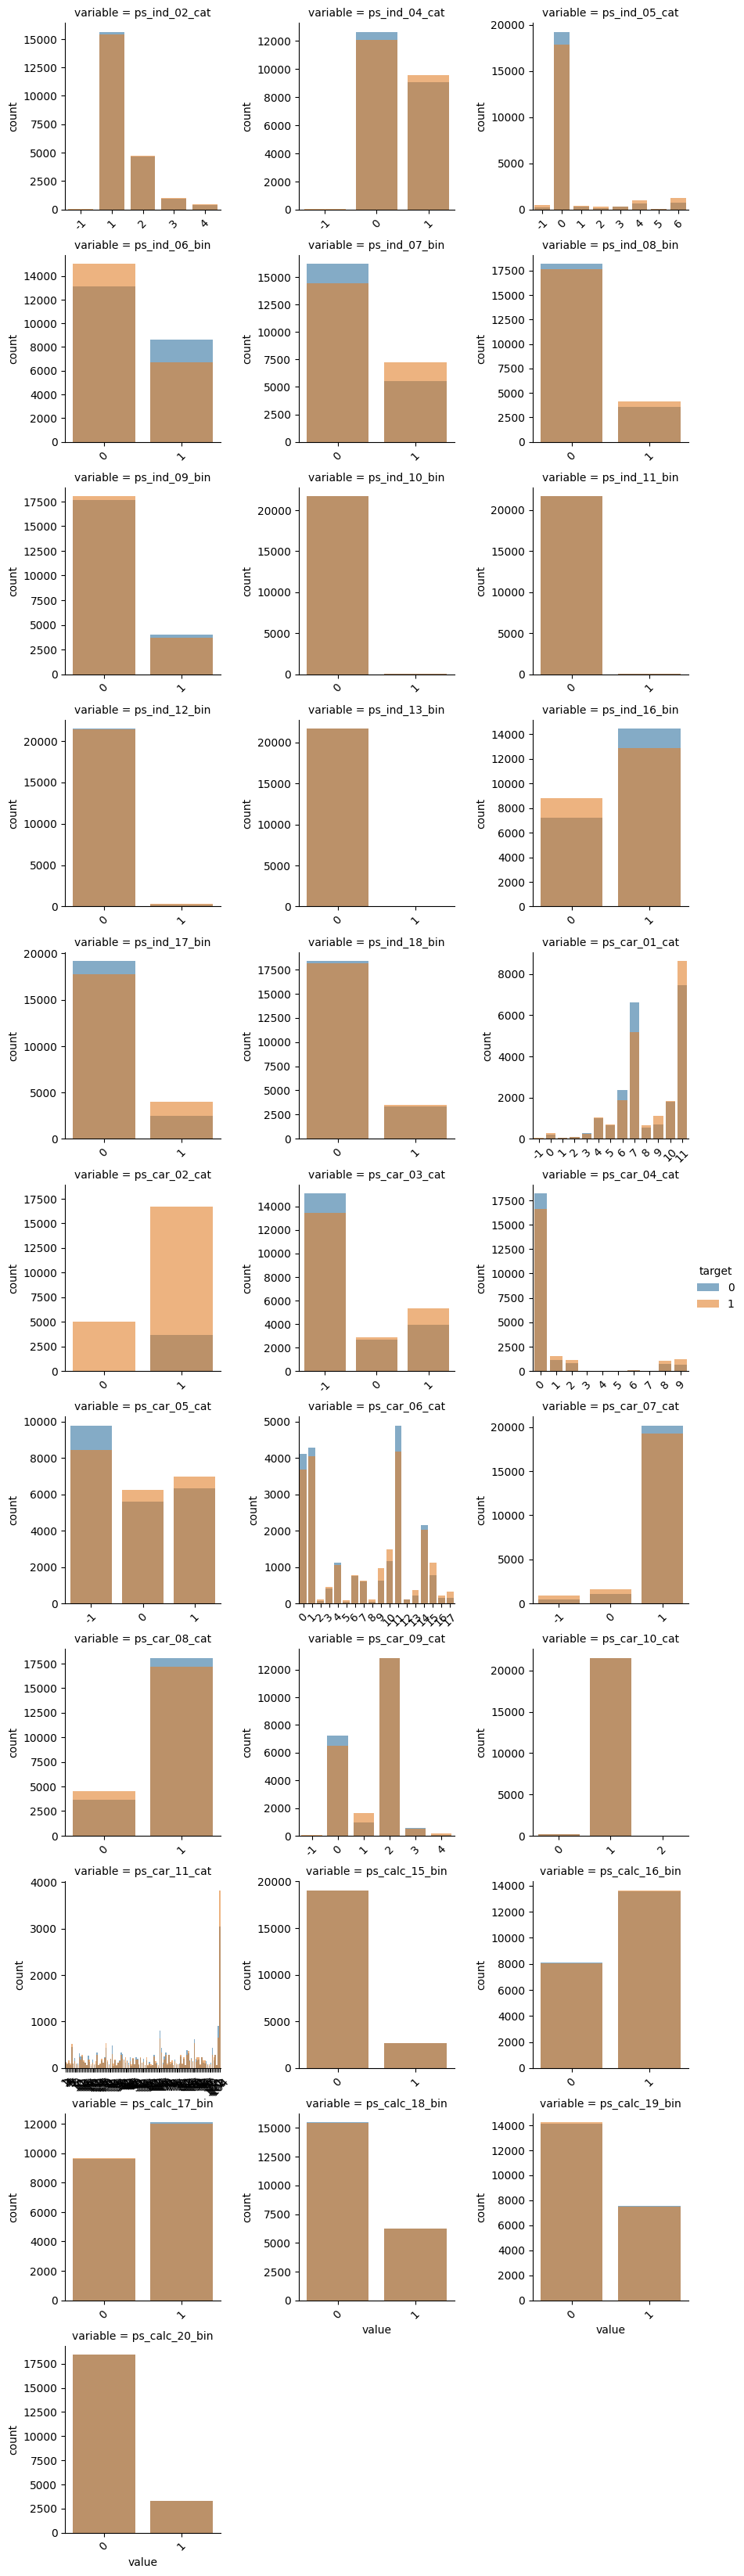

In [17]:

f = pd.melt(train_data, id_vars=['target'], value_vars=CAT_COLS)

# 使用Seaborn的FacetGrid并直接映射sns.countplot
g = sns.FacetGrid(f, col="variable", hue="target", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.countplot, "value", alpha=0.6).add_legend()

# 循环遍历每个轴并旋转x轴标签
for ax in g.axes.flat:
    # 获取当前x轴的标签
    labels = ax.get_xticklabels()
    # 设置新的x轴标签，带有旋转
    ax.set_xticklabels(labels, rotation=45)

plt.show()

某些二元特征极度偏斜：如 ps_ind_10_bin ~ ps_ind_13_bin 有 99%以上 的样本取值为0，仅 ~1% 为1 

ps_car_11_cat 竟然有 104 种不同的类别，且分布相对长尾（部分类别频数较低）。

  ps_car_01_cat、ps_car_06_cat 等 。对于**高基数（high cardinality）**分类特征，如果直接做独热编码（one-hot），维度会非常高，增加过拟合风险。

c:\Users\SEELE\.conda\envs\python_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


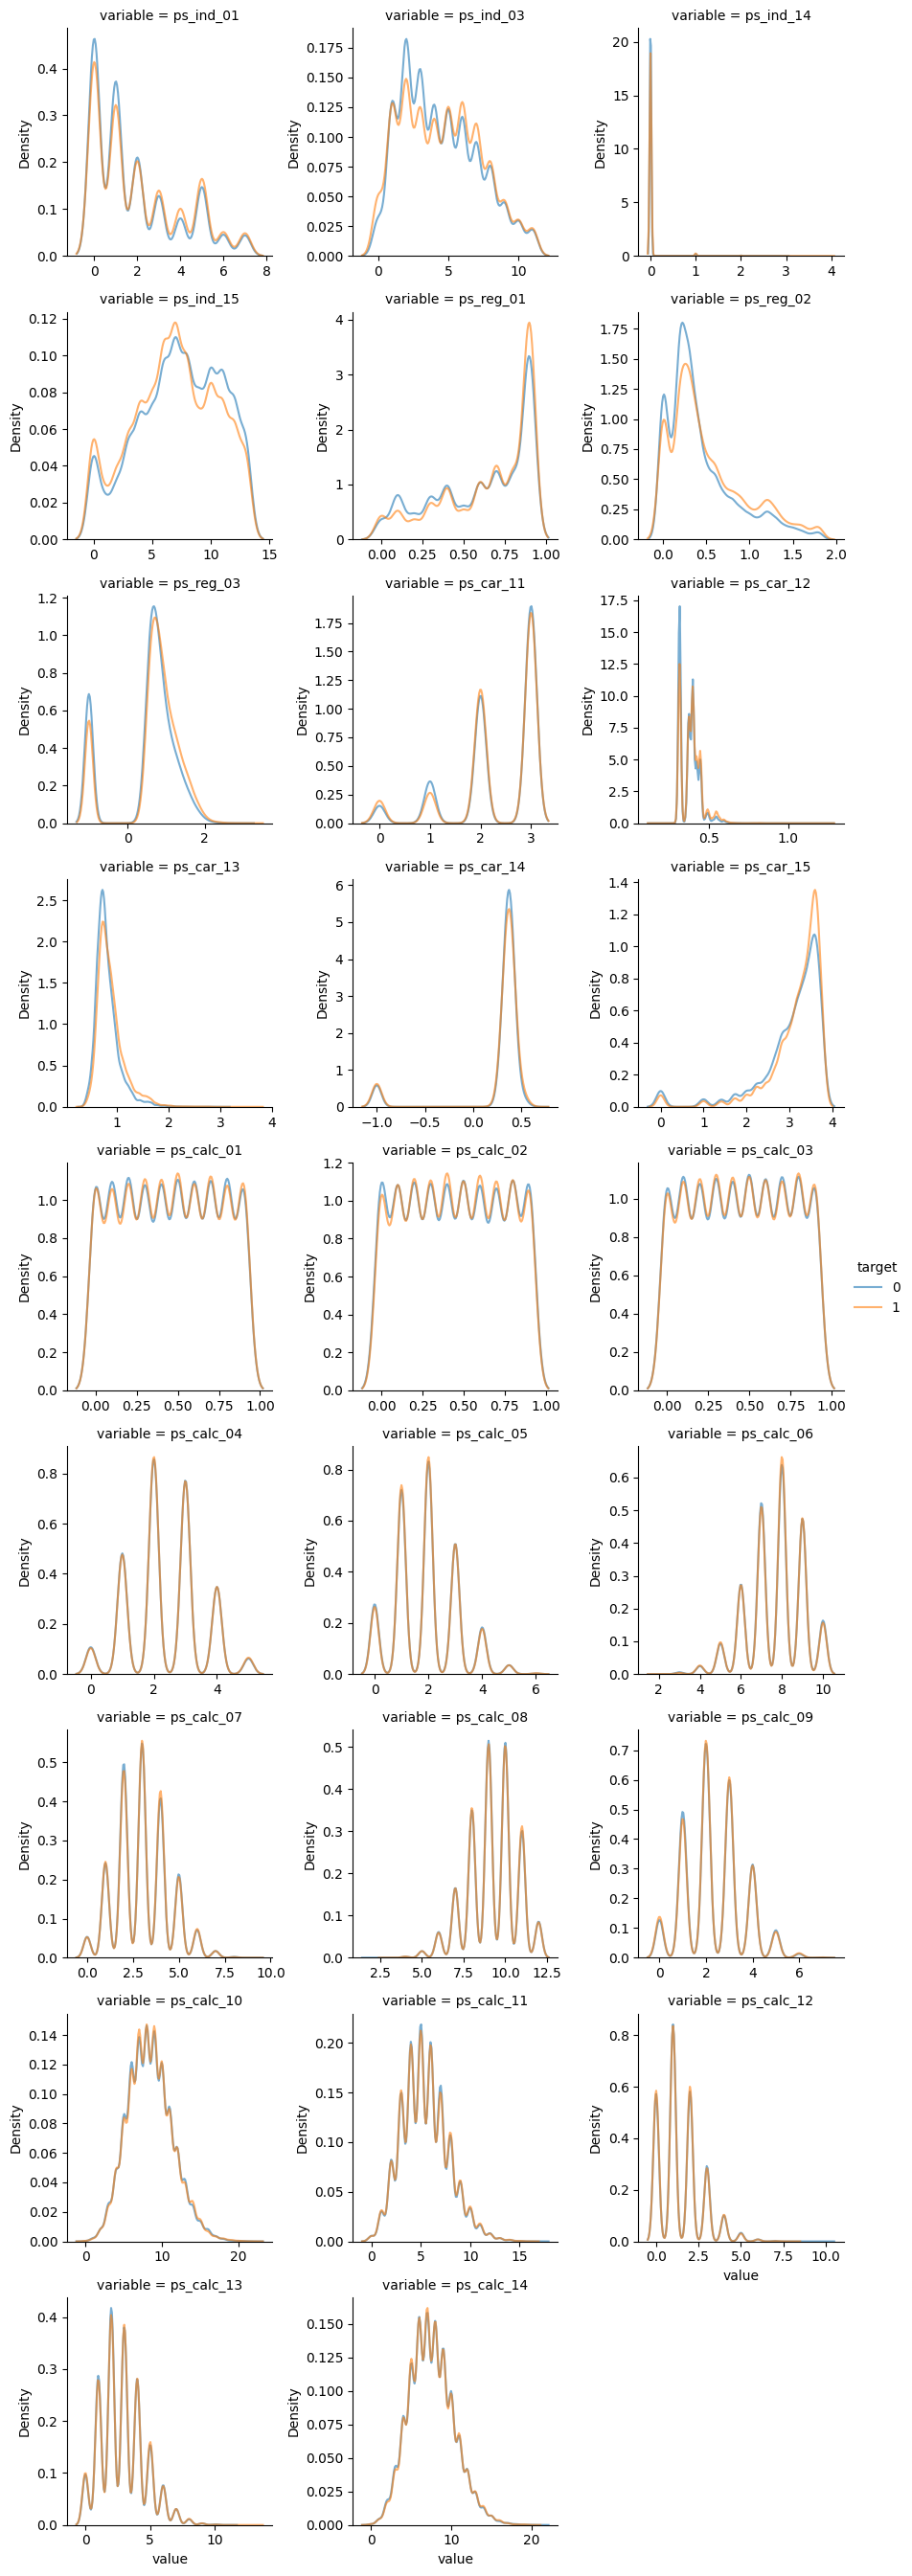

In [18]:
# # 查看连续数据的分布

f = pd.melt(train_data, id_vars=['target'], value_vars=NUM_COLS)
g = sns.FacetGrid(f, col="variable", hue="target", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.kdeplot, "value", alpha=0.6).add_legend()

.corr()

* 'pearson'：标准的皮尔逊相关系数。
* 'kendall'：Kendall Tau 相关系数。
* 'spearman'：Spearman 秩相关系数。

ps_ind_06_bin    -0.092108
ps_car_02_cat    -0.078710
ps_car_07_cat    -0.077897
ps_ind_16_bin    -0.075604
ps_ind_15        -0.058651
ps_car_08_cat    -0.051491
ps_ind_09_bin    -0.023153
ps_car_14        -0.014422
ps_calc_19_bin   -0.004455
ps_calc_12       -0.004344
ps_car_11        -0.004257
ps_calc_17_bin   -0.003432
ps_calc_15_bin   -0.002952
id               -0.001625
ps_calc_09       -0.000575
ps_calc_05       -0.000544
ps_calc_06       -0.000381
ps_calc_20_bin    0.000644
ps_ind_10_bin     0.001001
ps_ind_11_bin     0.001013
ps_calc_08        0.001655
ps_calc_18_bin    0.001782
ps_calc_11        0.002650
ps_calc_03        0.003002
ps_calc_16_bin    0.003147
ps_calc_04        0.003508
ps_calc_02        0.003559
ps_calc_07        0.003750
ps_calc_10        0.003866
ps_calc_01        0.004233
ps_calc_13        0.004283
ps_calc_14        0.004587
ps_ind_13_bin     0.005435
ps_car_10_cat     0.005511
ps_ind_02_cat     0.008742
ps_ind_18_bin     0.012982
ps_ind_14         0.015939
p

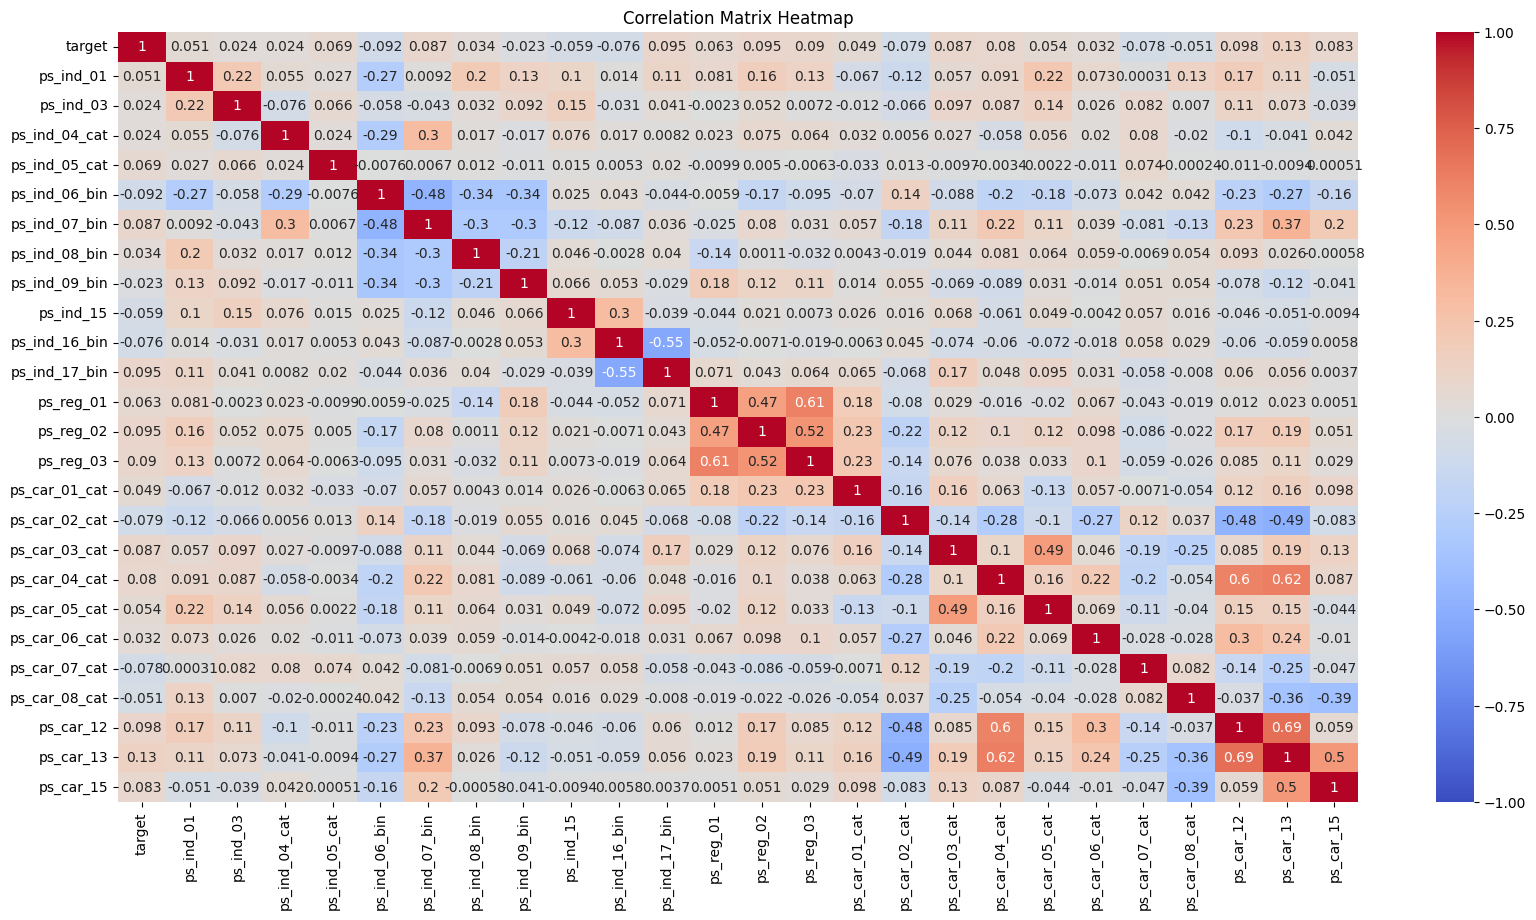

In [19]:

CorrDf = pd.DataFrame()
CorrDf = train_data.corr(method='pearson', min_periods=1)

#只显示与 target 相关性较高的特征，从而使得图表更加简洁和易于理解
print(CorrDf['target'].sort_values())
high_corr_features = CorrDf['target'].abs() > 0.02
corr_matrix_filtered = CorrDf.loc[high_corr_features, high_corr_features]

plt.figure(figsize=(20, 10))  
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# 显示图表
plt.title('Correlation Matrix Heatmap')
plt.show()

特征间冗余度不高，大部分特征提供的信息彼此比较独立

c:\Users\SEELE\.conda\envs\python_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


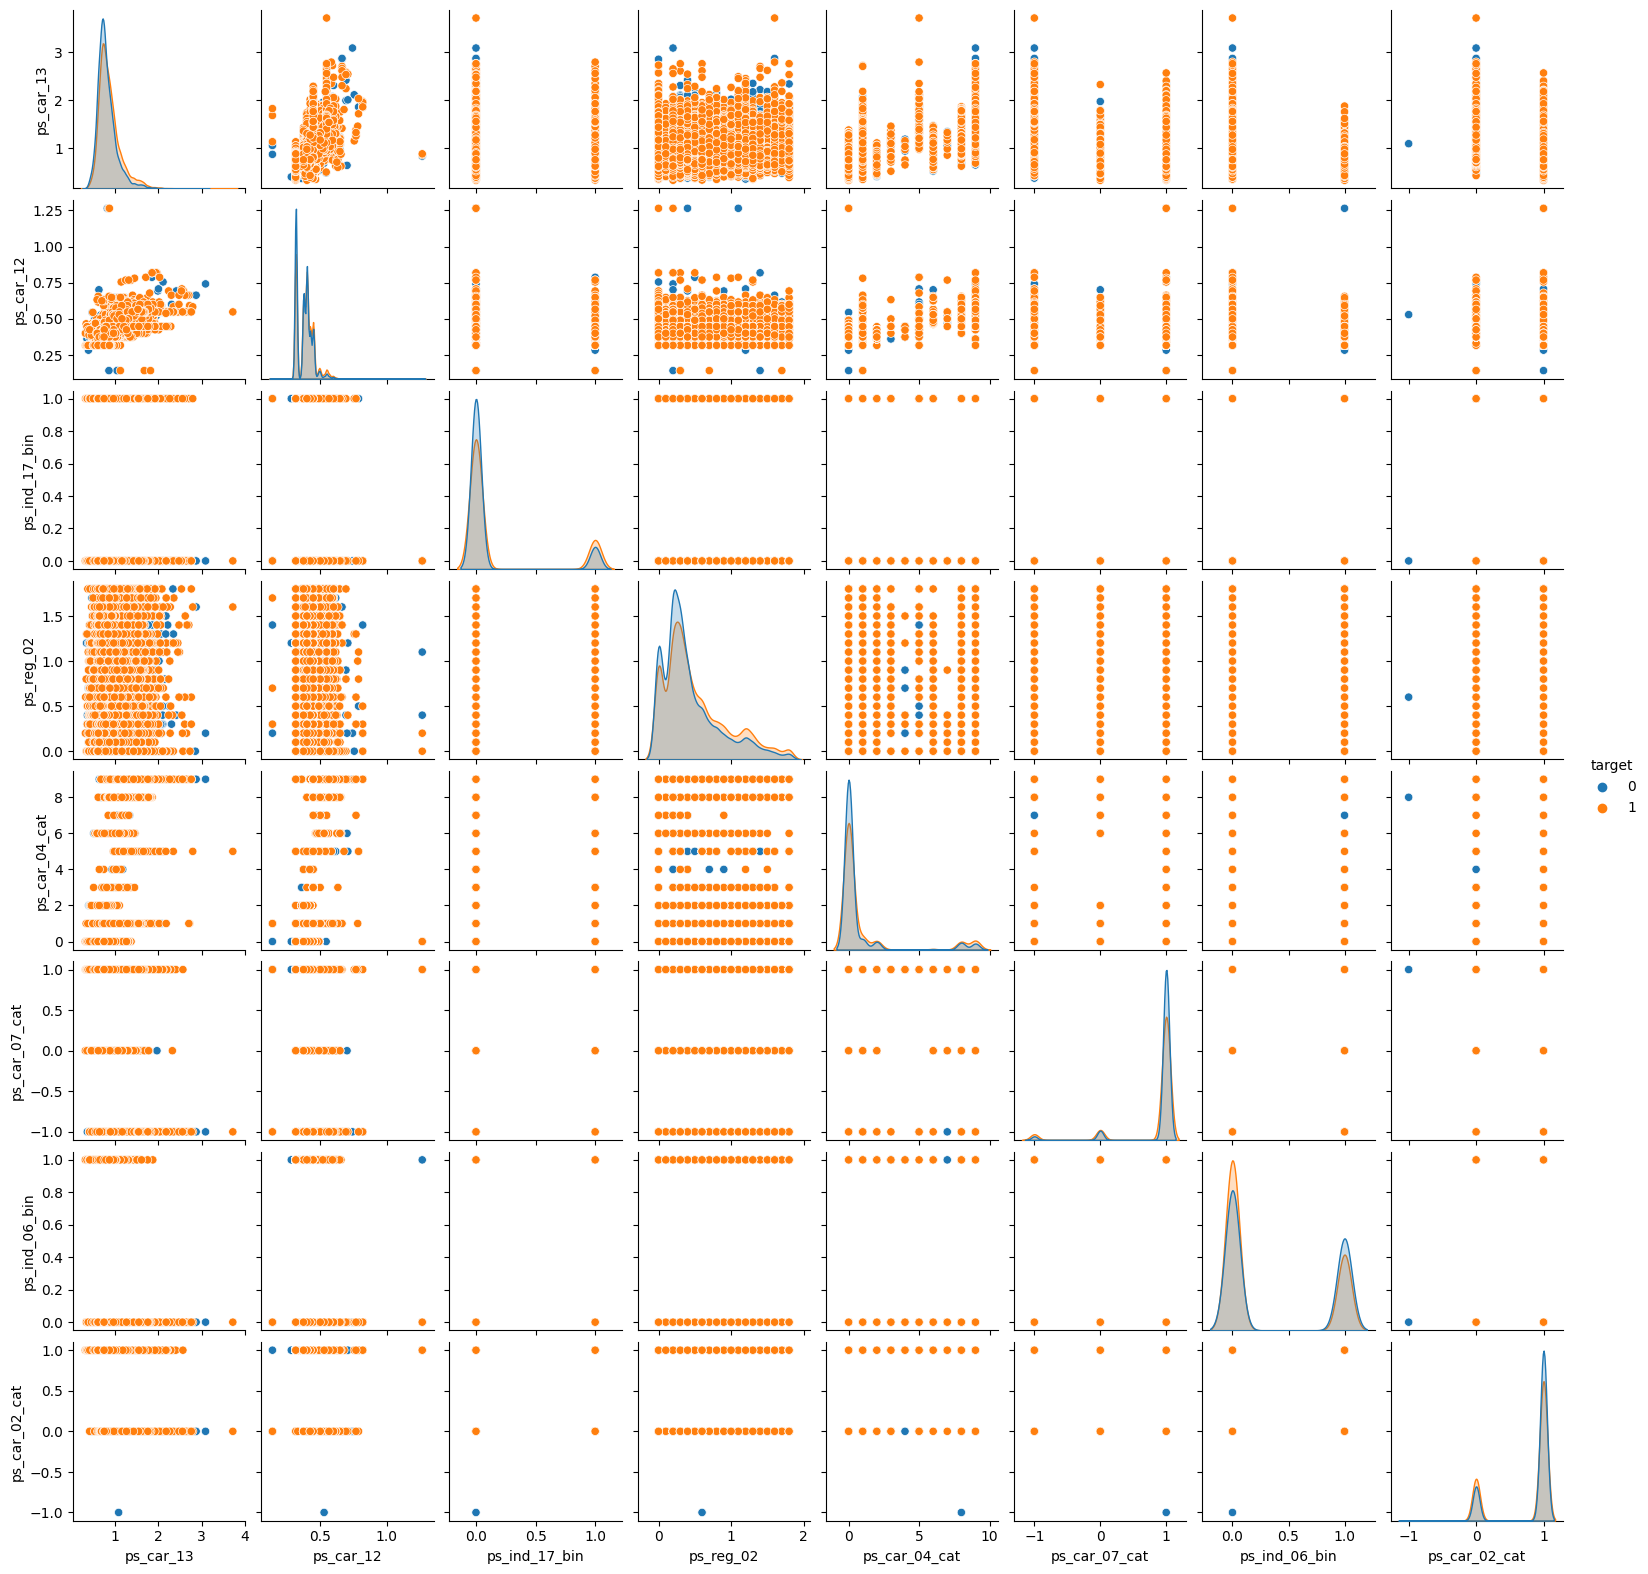

In [20]:

c = ['ps_car_13','ps_car_12','ps_ind_17_bin','ps_reg_02','ps_car_04_cat','ps_car_07_cat','ps_ind_06_bin','ps_car_02_cat']
sns.pairplot(train_data, vars=c, hue='target', height=2.0)
plt.show()


TODO:
1. -1的缺失值需要处理 占比较大的保留-1，占比较小的填充

| 特征名 | 数值 |
| --- | --- |
|ps_ind_02_cat : 216 -- 0.0004 |  |
|ps_ind_04_cat : 83 -- 0.0001 | |
|ps_ind_05_cat : 5809 -- 0.0098 | |
|ps_reg_03 : 107772 -- 0.1811 | |
|ps_car_01_cat : 107 -- 0.0002 | |
|ps_car_02_cat : 5 -- 0.0000 | |
|ps_car_03_cat : 411231 -- 0.6909 | retain |
|ps_car_05_cat : 266551 -- 0.4478 | retain |
|ps_car_07_cat : 11489 -- 0.0193 | |
|ps_car_09_cat : 569 -- 0.0010 | |
|ps_car_11 : 5 -- 0.0000 | |
|ps_car_12 : 1 -- 0.0000 | |
|ps_car_14 : 42620 -- 0.0716       | |

2. 数据不平衡需要处理
   


3. drop相关性不高的数据，主要是calc类型
4. 类别较多的数据需要处理  
   
| 特征名 | 数值 |
| --- | --- |
| ps_car_13 | 70482 |
| ps_car_14 | 850 |
| ps_reg_03 | 5013 |

# Data Process

In [21]:
# 整合数据，可以一起处理
# train_data = pd.concat([df_majority, df_minority], axis=0)62148512805727986214sdfsdffdsf1
full_data = pd.concat([train_data,test_data],ignore_index=True)

In [22]:
retainCols = ['ps_car_03_cat','ps_car_05_cat']
for col in retainCols:
    if col in MISSING_COLS:
        MISSING_COLS.remove(col)

for col in MISSING_COLS:
    if (full_data[col].isin([-1]).sum())>0 and ('cat' in col or 'bin' in col):
        full_data[col].fillna(full_data[col].mode()[0], inplace=True)
    elif (full_data[col].isin([-1]).sum())>0 and 'cat' not in col and 'bin' not in col:
        full_data[col].fillna(full_data[col].median(), inplace=True)
        full_data[col + '_missing'] = full_data[col].isnull().astype(int)
        print(col + '_missing')

ps_reg_03_missing
ps_car_11_missing
ps_car_14_missing


In [23]:
# Data Drop
DROP_COLS=[]
# 删除指定列
for col in train_data.columns:
    if 'calc' in col:
        DROP_COLS.append(col)                              
DROP_COLS.extend(['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin'])


full_data.drop(DROP_COLS, axis=1, inplace=True)

In [24]:
# Data Transformation
# 对每个分类特征应用标签编码
for col in CAT_COLS:
    if col in full_data.columns:
        full_data[col] = pd.Categorical(full_data[col])

In [25]:
full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936204 entries, 0 to 936203
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 936204 non-null  int64   
 1   target             43388 non-null   float64 
 2   ps_ind_01          936204 non-null  int64   
 3   ps_ind_02_cat      936204 non-null  category
 4   ps_ind_03          936204 non-null  int64   
 5   ps_ind_04_cat      936204 non-null  category
 6   ps_ind_05_cat      936204 non-null  category
 7   ps_ind_06_bin      936204 non-null  category
 8   ps_ind_07_bin      936204 non-null  category
 9   ps_ind_08_bin      936204 non-null  category
 10  ps_ind_09_bin      936204 non-null  category
 11  ps_ind_14          936204 non-null  int64   
 12  ps_ind_15          936204 non-null  int64   
 13  ps_ind_16_bin      936204 non-null  category
 14  ps_ind_17_bin      936204 non-null  category
 15  ps_ind_18_bin      936204 non-null

In [26]:
# # Data Discretization

# # 对数变换 有助于减少数据中的偏斜(skewness)，特别是当存在大量小值和少量极大值时 使得数据分布更加接近正态分布
# full_data['column_name'] = np.log1p(full_data['column_name'])

# # 找出数值型特征（列），并计算这些特征的偏度（skewness）。然后，它会筛选出那些偏度绝对值大于1的特征，并准备对这些特征进行对数变换以减少数据偏斜
# numeric_df = full_data.select_dtypes(['float64','int32','int64'])
# numeric_cols = numeric_df.columns.tolist()
# skewed_cols = full_data[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
# skewed_df = pd.DataFrame({'skew':skewed_cols})
# skew_cols = skewed_df[skewed_df['skew'].abs()>1].index.tolist()
# for col in skew_cols:
#     # 避免对含有0或负数的列直接取对数，可以先加上一个最小正值
#     min_val = full_data[col].min()
#     if min_val <= 0:
#         full_data[col] = full_data[col] - min_val + 1e-8  # 调整值域使所有值都大于0
#     full_data[col] = np.log(full_data[col])


# # 分箱（Binning）是一种将连续数据离散化的方法，可以减少异常值的影响，使模型更加稳定  
# # 划分到5个等宽的区间（bins）
# full_data['column_name'] = pd.cut(full_data['column_name'], bins=5, labels=False)


# #按自己的需求划分区间
# full_data.loc[full_data['column_name'] <= 7.91, 'column_name'] = 0
# full_data.loc[(full_data['column_name'] > 7.91) & (full_data['column_name'] <= 14.454), 'column_name'] = 1
# full_data.loc[(full_data['column_name'] > 14.454) & (full_data['column_name'] <= 31), 'column_name'] = 2
# full_data.loc[full_data['column_name'] > 31, 'column_name'] = 3



In [27]:
# Data Split
from sklearn.model_selection import train_test_split

target_column = 'target'
if target_column in full_data.columns:
    # 筛选出 target 列中有值的行作为训练集
    train_data = full_data[pd.notnull(full_data[target_column])].reset_index(drop=True)
    print(train_data.shape)
    # 筛选出 target 列中为空的行作为测试集
    test_data = full_data[full_data[target_column].isnull()].drop(columns=[target_column]).reset_index(drop=True)
else:
    print("指定的 target 列在数据集中找不到，请检查列名。")

X = train_data.drop('target', axis=1)  # 删除目标列，并将其余部分作为特征
Y = train_data['target']               # 目标变量

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42) 

(43388, 38)


# Model

In [28]:

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def normalized_gini(y_true, y_pred):
    # 计算AUC
    auc = roc_auc_score(y_true, y_pred)
    
    # 根据AUC计算原始Gini系数
    gini_coefficient = 2 * auc - 1
    
    # 计算正类样本的比例
    frac_pos = np.sum(y_true) / len(y_true)
    
    # 理论上Gini系数的最大值
    max_gini = (1 - frac_pos) / 2
    
    # 如果max_gini为0，则返回gini_coefficient；否则，返回标准化后的Gini系数
    if max_gini == 0:
        return gini_coefficient
    else:
        return gini_coefficient / max_gini

# 创建自定义评分器
gini_scorer = make_scorer(normalized_gini, greater_is_better=True)

In [29]:
#导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold


#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=5)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,
                                      X,Y,
                                      scoring=gini_scorer,
                                      cv=kfold,
                                      n_jobs=-1))

    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','LR','LinearDiscrimiAna']})

print(cvResDf)


    cv_mean    cv_std            algorithm
0 -2.643161  0.317974                  SVC
1 -1.673274  0.013328      DecisionTreeCla
2 -1.684343  0.045550      RandomForestCla
3 -0.912517  0.406627        ExtraTreesCla
4 -1.852312  0.015757  GradientBoostingCla
5  0.000000  0.000000                   LR
6 -0.146415  0.722450    LinearDiscrimiAna


In [30]:

parameters ={'n_estimators':[10,50,100,200,300,400,500],
             'criterion':['friedman_mse', 'squared_error'],
             'max_features':['sqrt','log2'],
             'min_samples_split': [2, 5, 10], 
             'min_samples_leaf': [1, 2, 4],  
             'learning_rate': [0.01, 0.1, 0.2],  
             }
#n_estimators 模型中基础估计器（通常是决策树）的数量。
model =GradientBoostingClassifier()
grid_search =GridSearchCV(model,parameters,scoring=gini_scorer,n_jobs=4) #n_jobs 用于指定并行作业的数量

grid_search.fit(X_train, Y_train)
print('best parameters:',grid_search.best_params_)
print('best score:',grid_search.best_score_)
# 预测
y_pred_rf = grid_search.predict(X_temp)
print("GB 验证集 AUC:", roc_auc_score(Y_temp, y_pred_rf))
print("GB 验证集 gini:", normalized_gini(Y_temp, y_pred_rf))
# def save_data(y_pred,filename):
#     submission=pd.DataFrame ( {
#     "Id" : test_data [ "Id" ],
#     "SalePrice" : y_pred.astype (int)
#     })
#     submission.to_csv ( filename+'_result.csv',index=False)
    
# save_data(y_pred_rf,'random')
# # 评估


best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
best score: 0.8088280233819736
GB 验证集 AUC: 0.5974608138674106
GB 验证集 gini: 0.7775957181195728


In [31]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(n_estimators=500, learning_rate=0.05,
                           num_leaves=32, max_depth=5,
                           subsample=0.8, colsample_bytree=0.8,
                           reg_alpha=0.1, reg_lambda=0.1,
                           class_weight={0:1, 1:RATIO}, # 或 scale_pos_weight=ratio
                           random_state=42, n_jobs=-1)
# 指定分类特征列索引
cat_feat_indices = [X_train.columns.get_loc(c) for c in CAT_COLS if c in X_train.columns] 
lgb_model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_temp, Y_temp)], 
    eval_metric='auc', 
    # early_stopping_rounds=30, 
    categorical_feature=cat_feat_indices, 
    feature_name='auto' 
)
y_pred_rf = lgb_model.predict_proba(X_temp)[:, 1]
print(y_pred_rf)
print("LightGBM 验证集 AUC:", roc_auc_score(Y_temp, y_pred_rf))
print("LightGBM 验证集 gini:", normalized_gini(Y_temp, y_pred_rf))


[LightGBM] [Info] Number of positive: 15203, number of negative: 15168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1403
[LightGBM] [Info] Number of data points in the train set: 30371, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963633 -> initscore=3.277058
[LightGBM] [Info] Start training from score 3.277058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: